In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

In [2]:
SEED = 42
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5  # seconds
FREQ_MIN = 500
FREQ_MAX = 15000
MAX_AUDIO_FILES = 100
WIN_LENGHT = 128
AUDIO_PATH = "/app/_data/birdclef-2021/train_short_audio/"

In [3]:
train_metadata = pd.read_csv("/app/_data/train_metadata.csv")
train_soundscape_labels = pd.read_csv("/app/_data/train_soundscape_labels_full.csv")

In [4]:
all_audio = pd.read_csv("/app/_data/all_audio.csv")

In [5]:
# train_metadata.to_csv("/app/_data/train_metadata.csv", index=False)
# train_soundscape_labels.to_csv("/app/_data/train_soundscape_labels_full.csv", index=False)

In [6]:
all_audio["sin_month"] = np.sin(2 * np.pi * all_audio["month"] / 12)
all_audio["cos_month"] = np.cos(2 * np.pi * all_audio["month"] / 12)
all_audio["sin_longitude"] = np.sin(2 * np.pi * (all_audio["longitude"]) / 360)
all_audio["cos_longitude"] = np.cos(2 * np.pi * (all_audio["longitude"]) / 360)
all_audio["norm_latitude"] = (all_audio["latitude"] - all_audio["latitude"].min()) / (
    all_audio["latitude"].max() - all_audio["latitude"].min()
)
all_audio = all_audio[all_audio["primary_label"].str.len() <= 7]
all_audio["secondary_labels"] = all_audio["secondary_labels"].fillna("nocall")
dict_birds = {}
for i, bird in enumerate(sorted(all_audio["primary_label"].unique())):
    dict_birds[bird] = i
all_audio["label_id"] = all_audio["primary_label"].replace(dict_birds)

In [7]:
dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
all_audio["num_intervals"] = all_audio["duration"] // 5
all_audio["start_sec"] = 0
all_audio["end_sec"] = 5

In [8]:
for i in all_audio.index.tolist():
    labels = all_audio.loc[i, "secondary_labels"].split(" ")
    list_ids = []
    for bird in labels:
        if bird in dict_birds.keys():
            list_ids.append(str(dict_birds[bird]))
        else:
            dict_birds[bird] = len(dict_birds)
            list_ids.append(str(dict_birds[bird]))
    all_audio.loc[i, "secondary_labels_id"] = " ".join(list_ids)
file_json = open("/app/_data/dict_birds.json", "w")
json.dump(dict_birds, file_json)
file_json.close()

In [122]:
all_audio["row_id"]

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
             ...      
65269    54955_SSW_580
65270    54955_SSW_585
65271    54955_SSW_590
65272    54955_SSW_595
65273    54955_SSW_600
Name: row_id, Length: 65030, dtype: object

In [3]:
random_cut = pd.read_csv("/app/_data/random_cut1.csv")
col = [
    "filename",
    "row_id",
    "start_sec",
    "end_sec",
    "label_id",
    "secondary_labels_id",
    "rating",
    "year",
    "file_path",
    "frames",
    "duration",
    "sin_month",
    "cos_month",
    "sin_longitude",
    "cos_longitude",
    "norm_latitude",
    "class_weights",
]
random_cut = random_cut[col]
random_cut[["start_sec", "end_sec", "rating"]] = random_cut[
    ["start_sec", "end_sec", "rating"]
].astype("float16")
random_cut[["year", "label_id"]] = random_cut[["year", "label_id"]].astype("int16")

In [4]:
random_cut.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686871 entries, 0 to 686870
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   filename             686871 non-null  object 
 1   row_id               686871 non-null  object 
 2   start_sec            686871 non-null  float16
 3   end_sec              686871 non-null  float16
 4   label_id             686871 non-null  int16  
 5   secondary_labels_id  686871 non-null  object 
 6   rating               686871 non-null  float16
 7   year                 686871 non-null  int16  
 8   file_path            686871 non-null  object 
 9   frames               686871 non-null  float64
 10  duration             686871 non-null  float64
 11  sin_month            686871 non-null  float64
 12  cos_month            686871 non-null  float64
 13  sin_longitude        686871 non-null  float64
 14  cos_longitude        686871 non-null  float64
 15  norm_latitude    

In [5]:
random_cut_sample = random_cut.sample(
    n=4000, weights="class_weights", random_state=SEED
).reset_index(drop=True)

In [9]:
with open("/app/_data/dict_birds.json", "r") as d:
    dict_birds1 = json.load(d)

In [399]:
# class MEL_Generator(keras.utils.Sequence):
class MEL_Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        n_fft,
        win_length,
        n_mels,
        sample_rate,
        mel_image_size,
        min_frequency,
        max_frequency,
        signal_lenght,
        return_primary_labels=True,
        return_secondary_labels=False,
        return_concat_labels = False,
        convert_to_rgb=True,
        norm_mel=True,
        wave_dir=None,
        long_mel_dir=None,
        short_mel_dir=None,
        hop_length=None,
        batch_size=32,
        shuffle=True,
        augmentation=None,
        sample_weight=True, 
    ):
        self.df = df
        self.n_fft = n_fft
        self.win_length = win_length
        self.n_mels = n_mels
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.min_frequency = min_frequency
        self.max_frequency = max_frequency
        self.signal_lenght = signal_lenght
        self.wave_dir = wave_dir
        self.long_mel_dir = long_mel_dir
        self.short_mel_dir = short_mel_dir
        self.norm_mel = norm_mel
        self.convert_to_rgb = convert_to_rgb
        self.sample_weight = sample_weight
        self.batch_size = batch_size
        self._shuffle = shuffle
        self.return_primary_labels = return_primary_labels
        self.return_secondary_labels = return_secondary_labels
        self.return_concat_labels = return_concat_labels
        if hop_length is None:
            self.hop_length = int(
                self.signal_lenght * self.sample_rate / self.mel_image_size - 1
            )
        else:
            self.hop_length = hop_length

        if self._shuffle:
            self._shuffle_samples()

    def __len__(self):
        return self.df.shape[0] // self._batch_size

    def _melspectrogram(self, wave):
        mel_spec = librosa.feature.melspectrogram(
            y=wave,
            sr=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mels,
            fmin=self.min_frequency,
            fmax=self.max_frequency,
        )
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        if self.norm_mel:
            mel_spec = (mel_spec - np.min(mel_spec)) / (
                np.max(mel_spec) - np.min(mel_spec)
            )
        mel_spec.astype(np.float32)
        return mel_spec

    def long_msg(
        self,
        wave,
        file_name,
        save_mel=True,
    ):
        long_mel_dir = self.long_mel_dir
        if long_mel_dir is not None:
            if os.path.isfile(long_mel_dir + file_name + ".npy"):
                mel_spec = np.load(long_mel_dir + file_name + ".npy")
            else:
                mel_spec = self._melspectrogram(wave)
        else:
            mel_spec = self._melspectrogram(wave)
        if long_mel_dir is not None and save_mel:
            if not os.path.isfile(long_mel_dir + file_name + ".npy"):
                if not os.path.exists(long_mel_dir):
                    os.mkdir(long_mel_dir)
                np.save(long_mel_dir + file_name, mel_spec)
        return mel_spec

    def get_audio(
        self,
        file_path,
    ):
        wave_dir = self.wave_dir
        file_name = file_path.split("/")[-1][:-4]

        if wave_dir is not None:
            if os.path.isfile(wave_dir + file_name + ".npy"):
                wave = np.load(wave_dir + file_name + ".npy")
            else:
                wave, sr = librosa.load(file_path, sr=self.sample_rate)
        else:
            wave, sr = librosa.load(file_path, sr=self.sample_rate)
        if wave_dir is not None:
            if not os.path.isfile(wave_dir + file_name + ".npy"):
                if not os.path.exists(wave_dir):
                    os.mkdir(wave_dir)
                np.save(wave_dir + file_name, wave)
        return wave, file_name

    def on_epoch_start(self):
        if self._shuffle:
            self._shuffle_samples()

    def __getitem__(self, batch_ix):
        assert batch_ix < self.df.shape[0]
        b_x, b_y, b_sw = [], [], []

        for i in range(self.batch_size):
            get_one = self._get_one(i + self.batch_size * batch_ix)
            b_x.append(get_one["image"])
            b_y.append(get_one["labels"])
            b_sw.append(get_one["sample_weight"])
        return b_x, b_y, b_sw

    def _get_one(self, ix):

        file_path = self.df.loc[ix, "file_path"]
        rating = self.df.loc[ix, "rating"]
        label_id = self.df.loc[ix, "label_id"]
        year = self.df.loc[ix, "year"]
        start_sec = self.df.loc[ix, "start_sec"]
        end_sec = self.df.loc[ix, "end_sec"]
        file_name = self.df.loc[ix, "filename"][:-4]
        new_filename = self.df.loc[ix, "row_id"][:-4]

        if os.path.isfile(self.short_mel_dir + new_filename + ".npy"):
            mel_spec = np.load(self.short_mel_dir + new_filename + ".npy")
        else:
            if os.path.isfile(self.long_mel_dir + file_name + ".npy"):
                long_mel_spec = np.load(self.long_mel_dir + file_name + ".npy")

            else:
                wave, filename = self.get_audio(
                    file_path,
                )
                long_mel_spec = self.long_msg(wave, filename, save_mel=True)

            mel_spec = long_mel_spec[
                :,
                int((start_sec * self.mel_image_size) / self.signal_lenght) : (
                    int(start_sec * self.mel_image_size / self.signal_lenght)
                    + self.mel_image_size
                )
            ]

            # return as rgb uint8 image
            if self.convert_to_rgb:
                mel_spec = np.round(
                    ((mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min()))
                    * 255
                )
                mel_spec = np.repeat(np.expand_dims(mel_spec.astype(np.uint8), 2), 3, 2)

                mel_spec[self.mel_image_size - 15 :, :20, 0] = (
                    255 * self.df.loc[ix, "sin_month"]
                )
                mel_spec[self.mel_image_size - 15 :, :20, 1] = 255
                mel_spec[self.mel_image_size - 15 :, :20, 2] = 0
                mel_spec[self.mel_image_size - 15 :, 20:40, 0] = 255
                mel_spec[self.mel_image_size - 15 :, 20:40, 1] = (
                    255 * self.df.loc[ix, "cos_month"]
                )
                mel_spec[self.mel_image_size - 15 :, 20:40, 2] = 0
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    0,
                ] = (
                    255 * self.df.loc[ix, "sin_longitude"]
                )
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    1,
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    2,
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    0,
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    1,
                ] = (
                    255 * self.df.loc[ix, "cos_longitude"]
                )
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    2,
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :, self.mel_image_size - 20 :, 0
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :, self.mel_image_size - 20 :, 1
                ] = 255
                mel_spec[self.mel_image_size - 15 :, self.mel_image_size - 20 :, 2] = (
                    255 * self.df.loc[ix, "norm_latitude"]
                )

                if not os.path.exists(self.short_mel_dir):
                    os.mkdir(self.short_mel_dir)
                np.save(self.short_mel_dir + new_filename, mel_spec)

        primary_y = np.zeros(self.df["label_id"].unique().shape[0])
        secondary_y = np.zeros(self.df["label_id"].unique().shape[0])

        assert self.return_primary_labels + self.return_concat_labels + self.return_secondary_labels == 1, 'only one of return_primary_labels, return_concat_labels or return_secondary_labels can be True'
        if self.return_primary_labels or self.return_concat_labels:
            primary_y[self.df.loc[ix, "label_id"]] = 1
            if self.return_primary_labels:
                y = primary_y
        if self.return_secondary_labels or self.return_concat_labels:
            for i in self.df.loc[ix, "secondary_labels_id"].split(" "):
                i = int(i)
                secondary_y[i] = 0.3
            if self.return_secondary_labels:
                y= secondary_y

        if self.return_concat_labels:
            y = primary_y+secondary_y
            y = np.where(y>1,1,y)
        

        # sample weight
        if self.sample_weight:
            sw = self.df.loc[ix, "class_weights"]  # type: ignore

        assert mel_spec.shape == (self.n_mels, self.mel_image_size, 3) or (self.n_mels, self.mel_image_size)
        return {
            "image": mel_spec,
            "labels": y,
            "sample_weight": sw,
        }

    def _shuffle_samples(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)

In [400]:
shutil.rmtree("/app/_data/npy/")
os.mkdir("/app/_data/npy/")

In [401]:
mg = MEL_Generator(
    df=random_cut_sample,
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=5,
    wave_dir="/app/_data/npy/waves_npy/",
    long_mel_dir="/app/_data/npy/long_mels/",
    short_mel_dir="/app/_data/npy/short_mels/",
    norm_mel=True,
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels = True,
    return_secondary_labels = False,
    return_concat_labels=False
)

In [402]:
dc = mg.__getitem__(0)

In [363]:
dc[1][0]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0.

In [343]:
dc[0][0]

array([[[118, 118, 118],
        [127, 127, 127],
        [141, 141, 141],
        ...,
        [129, 129, 129],
        [122, 122, 122],
        [119, 119, 119]],

       [[119, 119, 119],
        [127, 127, 127],
        [141, 141, 141],
        ...,
        [128, 128, 128],
        [121, 121, 121],
        [117, 117, 117]],

       [[121, 121, 121],
        [127, 127, 127],
        [140, 140, 140],
        ...,
        [128, 128, 128],
        [120, 120, 120],
        [116, 116, 116]],

       ...,

       [[129, 255,   0],
        [129, 255,   0],
        [129, 255,   0],
        ...,
        [255, 255, 164],
        [255, 255, 164],
        [255, 255, 164]],

       [[129, 255,   0],
        [129, 255,   0],
        [129, 255,   0],
        ...,
        [255, 255, 164],
        [255, 255, 164],
        [255, 255, 164]],

       [[129, 255,   0],
        [129, 255,   0],
        [129, 255,   0],
        ...,
        [255, 255, 164],
        [255, 255, 164],
        [255, 255, 164]]

In [248]:
random_cut_sample.head(10)

,filename,row_id,start_sec,end_sec,label_id,secondary_labels_id,rating,year,file_path,frames,duration,sin_month,cos_month,sin_longitude,cos_longitude,norm_latitude,class_weights
0,XC135944.ogg,XC135944.ogg_9_33,4.328125,9.328125,144,178 348,4.5,1990,/app/_data/train_short_audio/gilwoo/XC135944.ogg,372437.0,11.638656,-5.000000e-01,-8.660254e-01,-0.932561,-0.361013,0.646505,0.010000
1,XC509717.ogg,XC509717.ogg_99_18,94.187500,99.187500,378,220,4.0,2019,/app/_data/train_short_audio/wooduc/XC509717.ogg,3664544.0,114.517000,-5.000000e-01,8.660254e-01,-0.839283,-0.543695,0.775264,0.020408
2,XC525212.ogg,XC525212.ogg_33_57,28.562500,33.562500,289,220,0.0,2001,/app/_data/train_short_audio/rudpig/XC525212.ogg,1328728.0,41.522750,5.000000e-01,8.660254e-01,-0.953312,0.301986,0.404114,0.007463
3,XC558712.ogg,XC558712.ogg_74_93,69.937500,74.937500,233,216 316 180 214 323,3.5,2020,/app/_data/train_short_audio/olsfly/XC558712.ogg,8020640.0,250.645000,5.000000e-01,-8.660254e-01,-0.859439,-0.511238,0.670651,0.008264
4,XC307060.ogg,XC307060.ogg_9_56,4.558594,9.562500,61,220,4.0,1999,/app/_data/train_short_audio/brratt1/XC307060.ogg,1060398.0,33.137437,-1.000000e+00,-1.836970e-16,-0.954675,0.297651,0.331935,0.003774
5,XC303087.ogg,XC303087.ogg_25_26,20.265625,25.265625,61,220,5.0,2016,/app/_data/train_short_audio/brratt1/XC303087.ogg,1756832.0,54.901000,5.000000e-01,8.660254e-01,-0.884944,0.465698,0.413662,0.003774
6,XC80108.ogg,XC80108.ogg_29_51,24.515625,29.515625,22,220,4.5,1999,/app/_data/train_short_audio/barant1/XC80108.ogg,1100522.0,34.391312,5.000000e-01,-8.660254e-01,-0.663609,0.748080,0.307605,0.005051
7,XC184465.ogg,XC184465.ogg_26_39,21.390625,26.390625,347,220,5.0,2014,/app/_data/train_short_audio/veery/XC184465.ogg,3580692.0,111.896625,1.224647e-16,-1.000000e+00,-0.937859,0.347016,0.766930,0.005587
8,XC66063.ogg,XC66063.ogg_10_1,5.109375,10.101562,234,220,5.0,2008,/app/_data/train_short_audio/orbeup1/XC66063.ogg,3436914.0,107.403563,5.000000e-01,8.660254e-01,-0.925111,0.379697,0.480817,0.006757
9,XC341002.ogg,XC341002.ogg_28_66,23.656250,28.656250,279,220,2.5,2016,/app/_data/train_short_audio/rthhum/XC341002.ogg,1018602.0,31.831312,-8.660254e-01,5.000000e-01,-0.998836,0.048240,0.507373,0.029412


In [173]:
mel_spec1 = np.round(
    (dc[0][0] - np.min(dc[0][0])) / (np.max(dc[0][0]) - np.min(dc[0][0])) * 255
)

In [290]:
a = mg._get_one(1)

In [291]:
a["image"].shape

(260, 5969)

In [293]:
260 * a["start_sec"]

24488.75

In [267]:
for i in os.listdir("/app/_data/npy/long_mels/"):
    a = np.load("/app/_data/npy/long_mels/" + i)
    a.shape

(260, 607)

In [56]:
b = np.load("/app/_data/npy/short_mels/XC392250.ogg_59_02.npy")

In [57]:
b.shape

(260, 260, 3)

In [86]:
a["image"].max()

0.6519136

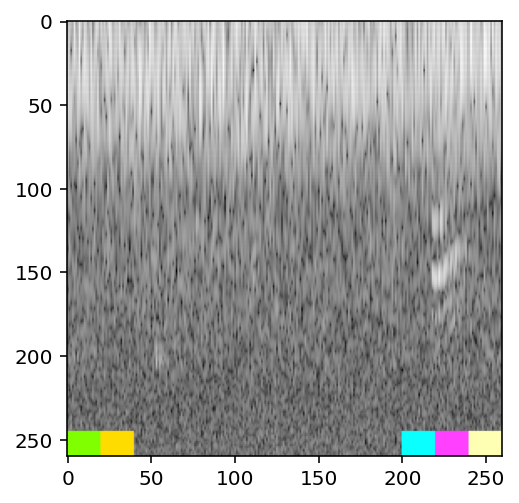

In [344]:
plt.imshow(dc[0][11])

In [97]:
dc[3][1]

0.0075187969924812

In [19]:
a["sample_weight"]

0.009433962264150943

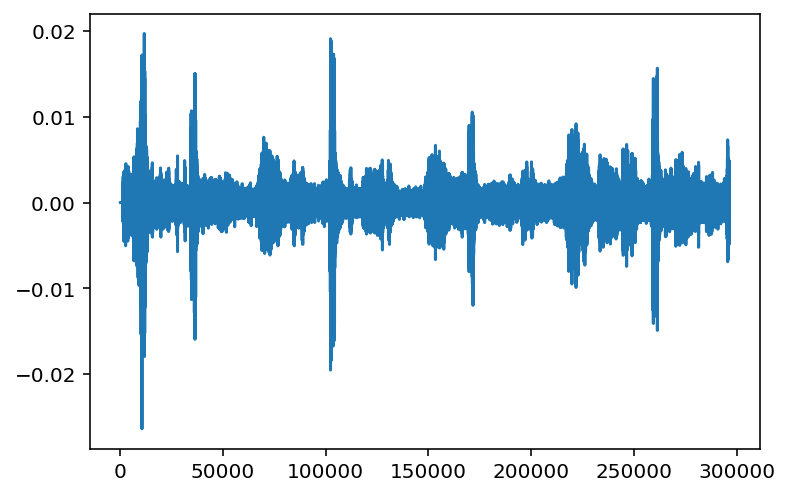

In [985]:
plt.plot(wave1)

In [986]:
msgr = mg.long_msg(
    wave1,
    n1,
    save_mel=True,
)

In [987]:
msgr

array([[ 1.1468413 ,  1.1468413 ,  0.4447199 , ..., -0.15271014,
        -0.07608284, -0.00921803],
       [ 1.1468413 ,  1.1468413 ,  0.44294575, ..., -0.15132952,
        -0.0778601 , -0.00812899],
       [ 1.1468413 ,  1.1468413 ,  0.44114956, ..., -0.14984545,
        -0.07966015, -0.00728876],
       ...,
       [ 1.1468413 ,  1.1468413 ,  0.4986587 , ...,  0.18272735,
         0.40510646,  0.21673486],
       [ 1.1468413 ,  1.1468413 ,  0.45383504, ...,  0.37111604,
         0.3538761 ,  0.15523736],
       [ 1.1468413 ,  1.1468413 ,  0.40816015, ...,  0.36655667,
         0.24536556,  0.11715984]], dtype=float32)

In [988]:
n1

'XC310335'

In [27]:
SEED = 42
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5  # seconds
FREQ_MIN = 500
FREQ_MAX = 15000
MAX_AUDIO_FILES = 100
WIN_LENGHT = 128
AUDIO_PATH = "/app/_data/birdclef-2021/train_short_audio/"

In [289]:
a = mg.msg(wave=wave1[:16000])
a.max()

-1.9e-06

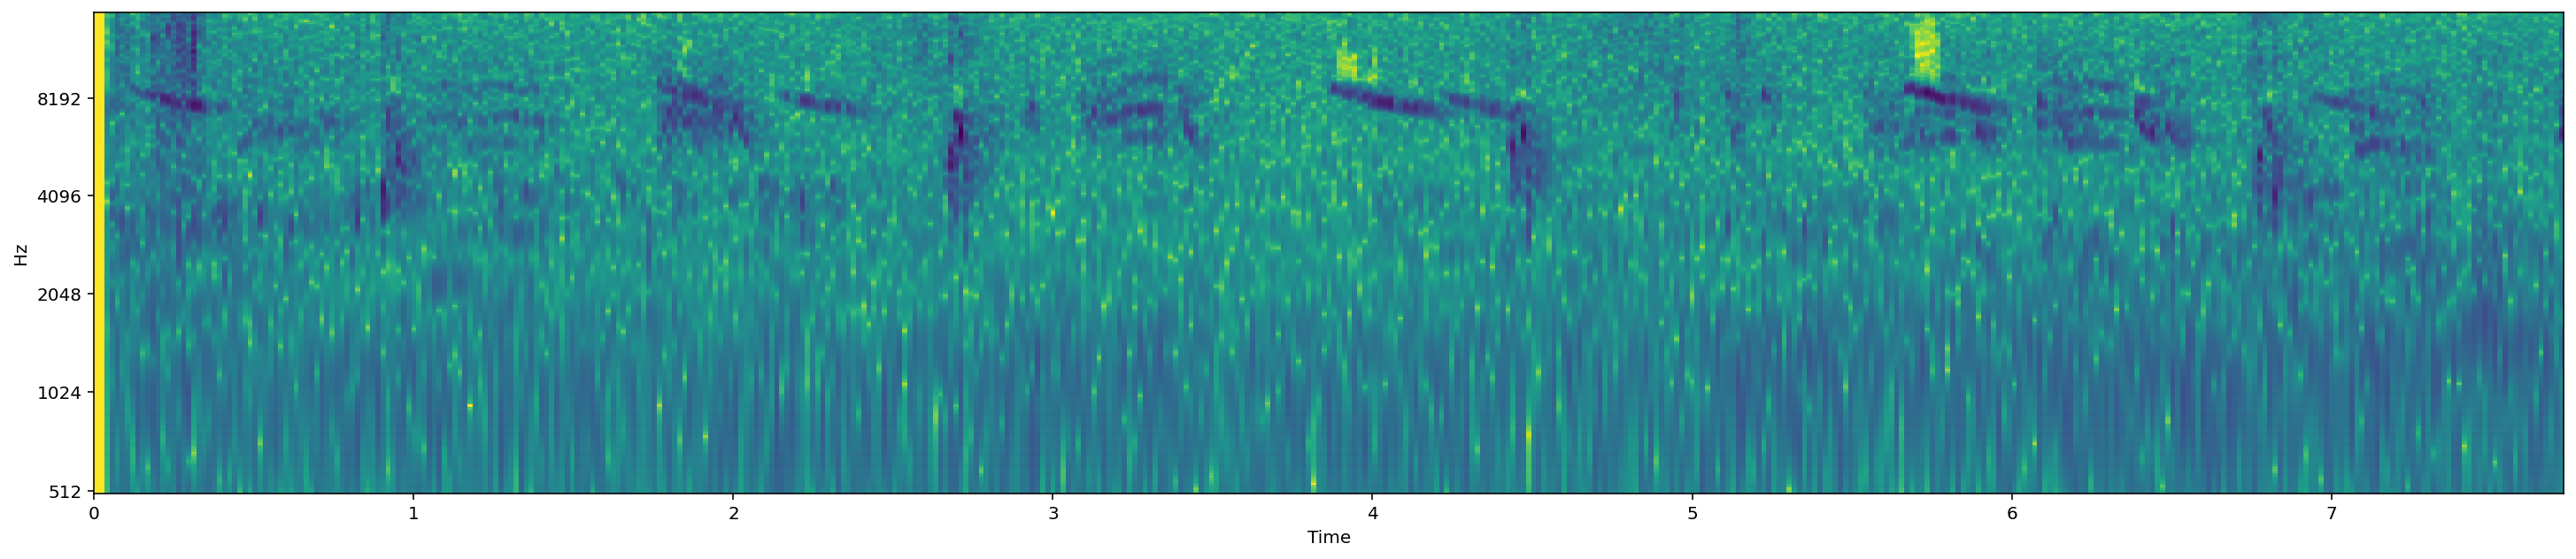

In [989]:
plt.figure(figsize=(25, 5))
# plt.imshow(abs(a[:,:520]))
librosa.display.specshow(
    msgr,
    sr=32000,
    x_axis="time",
    y_axis="mel",
    fmin=FREQ_MIN,
    fmax=FREQ_MAX,
    cmap=plt.get_cmap("viridis"),
)
plt.show();

In [ ]:
# class MEL_Generator(keras.utils.Sequence):
class MEL_Generator:
    def __init__(
        self,
        df,
        n_fft,
        win_length,
        n_mels,
        sample_rate,
        mel_image_size,
        min_frequency,
        max_frequency,
        signal_lenght,
        hop_length=None,
        device="cpu",
    ):
        self.df = df
        self.n_fft = n_fft
        self.win_length = win_length
        self.n_mels = n_mels
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.min_frequency = min_frequency
        self.max_frequency = max_frequency
        self.signal_lenght = signal_lenght
        self._device = device
        if hop_length is None:
            self.hop_length = int(
                self.signal_lenght * self.sample_rate / self.mel_image_size - 1
            )
        else:
            self.hop_length = hop_length

    def melspectrogram(self, wave, normalize=True):
        mel_spec = librosa.feature.melspectrogram(
            y=wave,
            sr=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mels,
            fmin=self.min_frequency,
            fmax=self.max_frequency,
        )
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        if normalize:
            mel_spec = (mel_spec - np.mean(mel_spec)) / np.mean(mel_spec)
            mel_spec.astype(np.float16)
        return mel_spec

    def msg(
        self,
        wave,
        file_name,
        start_sec=None,
        n_samples=None,
        mel_dir=None,
        save_mel=False,
        normalize=False,
    ):x
        if mel_dir is not None:
            if os.path.exists(mel_dir + file_name + ".npy"):
                mel_spec = np.load(mel_dir + file_name + ".npy")
            else:
                mel_spec = melspectrogram(wave, normalize=normalize)
        #                 mel_spec = librosa.feature.melspectrogram(
        #                     y=wave,
        #                     sr=self.sample_rate,
        #                     n_fft=self.n_fft,
        #                     hop_length=self.hop_length,
        #                     win_length=self.win_length,
        #                     n_mels=self.n_mels,
        #                     fmin=self.min_frequency,
        #                     fmax=self.max_frequency,
        #                 )
        #                 mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        #                 if normalize:
        #                     mel_spec = (mel_spec - np.mean(mel_spec)) / np.mean(mel_spec)
        #                     mel_spec.astype(np.float16)
        else:
            mel_spec = melspectrogram(wave, normalize=normalize)
        #             mel_spec = librosa.feature.melspectrogram(
        #                 y=wave,
        #                 sr=self.sample_rate,
        #                 n_fft=self.n_fft,
        #                 hop_length=self.hop_length,
        #                 win_length=self.win_length,
        #                 n_mels=self.n_mels,
        #                 fmin=self.min_frequency,
        #                 fmax=self.max_frequency,
        #             )
        #             mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        #             # normalisation of the whole mel_spec
        #             if normalize:
        #                 mel_spec = (mel_spec - np.mean(mel_spec)) / np.mean(mel_spec)
        #                 mel_spec.astype(np.float16)
        if mel_dir is not None and save_mel:
            if not os.path.exists(mel_dir):
                os.mkdir(mel_dir)
            if not os.path.exists(mel_dir + file_name + ".npy"):
                np.save(mel_dir + file_name, mel_spec)

        return mel_spec

    def get_audio_fragment(
        self,
        file_path,
        start_sec=None,
        n_samples=None,
        wave_dir=None,
    ):
        file_name = file_path.split("/")[-1][:-4]

        if wave_dir is not None:
            if os.path.exists(wave_dir + file_name + ".npy"):
                wave = np.load(wave_dir + file_name + ".npy")
            else:
                wave, sr = librosa.load(file_path, sr=self.sample_rate)
        else:
            wave, sr = librosa.load(file_path, sr=self.sample_rate)

        if start_sec is not None:
            start_sample = int(start_sec * self.sample_rate)
            end_sample = int(self.sample_rate * (start_sec + self.signal_lenght))
            wave = wave[start_sample:end_sample]
        wave = wave.astype(np.float16)

        if wave_dir is not None:
            if not os.path.exists(wave_dir + file_name + ".npy"):
                if not os.path.exists(wave_dir):
                    os.mkdir(wave_dir)
                    np.save(wave_dir + file_name, wave)
        return wave, file_name